In [1]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
from tqdm.notebook import tqdm_notebook
#from kneed import KneeLocator
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
#from scipy.optimize import curve_fit
from tqdm import tqdm

# Read data

In [2]:
df = pd.read_csv('./Pleiades_10.csv')
#df.loc[df['ra'] > 300, 'ra'] -= 360 #SOLO PARA BLANCO 1
#c_pm = (df['pmra'] > -30) & (df['pmra'] < 0) & (df['pmdec'] > 0) & (df['pmdec'] < 30)
#df = df[c_pm]
df = df.fillna(0)
df['parallax'] = df['parallax'] / 1000
df['parallax_error'] = df['parallax_error'] / 1000
print(df.shape)
df

(86964, 23)


,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,...,rp,rp_error,bp,bp_error,visibility_periods_used,astrometric_excess_noise,ruwe,phot_bp_rp_excess_factor,dr2_radial_velocity,dr2_radial_velocity_error
0,39595028624086784,58.925555,0.179238,14.508723,0.121958,0.002619,0.000209,4.215698,0.234560,-0.700546,...,17.390646,8.220617,20.101917,6.740799,16,0.000000,0.944329,1.481405,0.000000,0.000000
1,43077220605675776,55.857881,0.013936,15.380339,0.011246,0.002029,0.000016,9.192065,0.017599,3.363065,...,9.944870,382.718350,11.307915,245.030800,16,0.076344,1.093171,1.255964,53.365173,0.332817
2,43077942160182912,55.797964,0.047561,15.396144,0.035990,0.003142,0.000054,-23.991604,0.061696,-32.783754,...,14.908102,16.819826,17.301136,9.598823,16,0.154507,1.099787,1.416438,0.000000,0.000000
3,43079728866580992,55.673353,0.013689,15.401801,0.011009,0.005192,0.000015,3.940656,0.017991,-39.107899,...,10.282437,281.223080,11.168148,278.789730,15,0.057734,1.028618,1.211046,33.327717,0.502663
4,43079827649252224,55.684030,0.140340,15.409352,0.113582,0.004014,0.000159,-1.011654,0.183765,-9.359367,...,16.793060,8.395981,19.847322,7.613711,15,0.424174,1.044966,1.496208,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86959,162488306552939136,60.800166,0.064476,25.805909,0.036136,0.002018,0.000072,12.695988,0.081633,-6.265630,...,15.606716,10.053244,17.548681,11.552420,15,0.000000,0.993849,1.319838,0.000000,0.000000
86960,162488409632150144,60.798569,0.090249,25.838042,0.048979,0.002116,0.000100,-10.033589,0.116109,-17.855379,...,16.106064,13.984496,18.423088,6.961178,15,0.118407,1.062208,1.384791,0.000000,0.000000
86961,162488787589261696,60.876073,0.058052,25.857109,0.034374,0.002759,0.000063,41.369297,0.068731,-16.852251,...,15.417825,9.491437,17.720125,9.373974,16,0.000000,1.065508,1.380453,0.000000,0.000000
86962,162489131186659328,60.766976,0.017386,25.830142,0.009290,0.002159,0.000018,13.940628,0.020750,-15.556109,...,11.599663,51.354260,12.460117,79.931360,15,0.080726,0.978119,1.205441,34.452797,1.112115


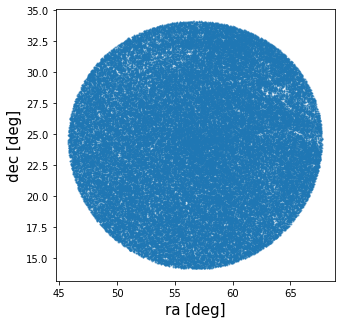

In [5]:
plt.figure(figsize=(5,5))
plt.scatter(df['ra'], df['dec'], marker='o' , s=1, alpha = 0.5)
plt.xlabel("ra [deg]",  fontsize = 15)
plt.ylabel("dec [deg]",  fontsize = 15)#,rotation=0)
#plt.xlim(-30,0)
#plt.ylim(0,30)
plt.show()

#plt.figure(figsize=(5,5))
#plt.scatter(df['pmra'], df['pmdec'], marker='o' , s=5, alpha = 0.5)
#plt.xlabel("pmra [mas $yr^{-1}$]",  fontsize = 15)
#plt.ylabel("pmdec [mas $yr^{-1}$]",  fontsize = 15)#,rotation=0)
#plt.xlim(-30,0)
#plt.ylim(0,30)
#plt.show()

# Generate data

In [6]:
def pdf(x, mu, std):
    return 1/np.sqrt(2*np.pi*std**2) * np.exp(-(x-mu)**2 / (2*std**2))

def metropolis_hastings(x, mu, std, delta=0.1):
    x_new = x + (np.random.random()-0.5)*2.0*delta
    gamma = min(1, pdf(x_new, mu, std)/pdf(x, mu, std))
    alpha = np.random.random()
    if alpha < gamma:
        x = x_new
    return x

  0%|                                                    | 0/30 [00:00<?, ?it/s]

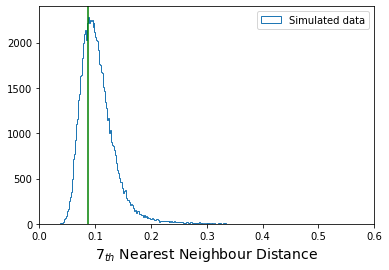

  3%|█▍                                          | 1/30 [00:04<02:20,  4.84s/it]

0.08718338778243558


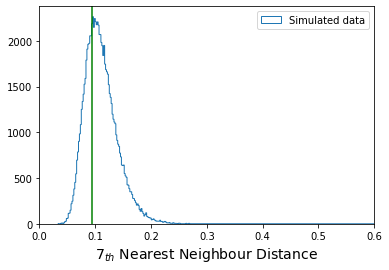

  7%|██▉                                         | 2/30 [00:09<02:16,  4.87s/it]

0.09506998964922951


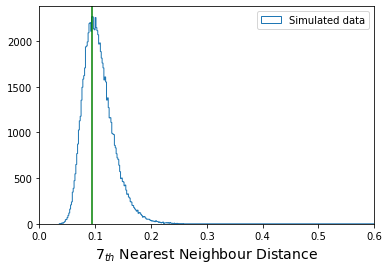

 10%|████▍                                       | 3/30 [00:15<02:16,  5.06s/it]

0.09346410009958339


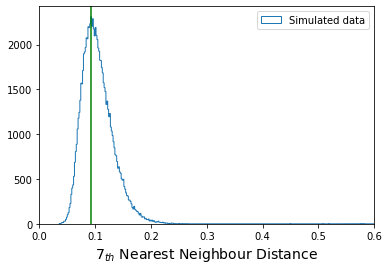

 13%|█████▊                                      | 4/30 [00:19<02:06,  4.87s/it]

0.0917382828355827


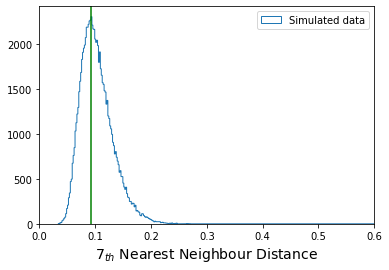

 17%|███████▎                                    | 5/30 [00:24<02:00,  4.82s/it]

0.0923385741731773


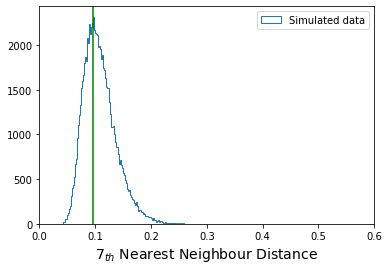

 20%|████████▊                                   | 6/30 [00:29<01:55,  4.81s/it]

0.09686360930533522


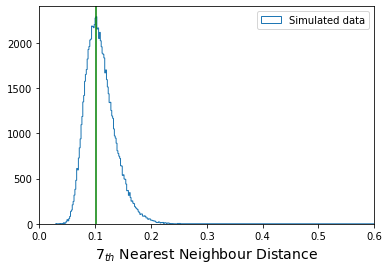

 23%|██████████▎                                 | 7/30 [00:35<01:58,  5.16s/it]

0.10124791982414784


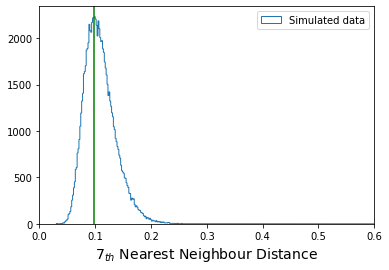

 27%|███████████▋                                | 8/30 [00:40<01:53,  5.14s/it]

0.09839717094612253


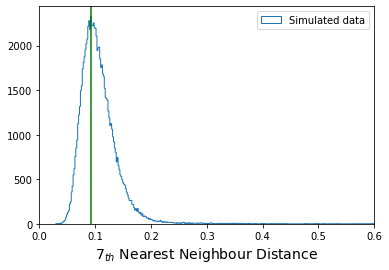

 30%|█████████████▏                              | 9/30 [00:45<01:48,  5.16s/it]

0.09152874244048206


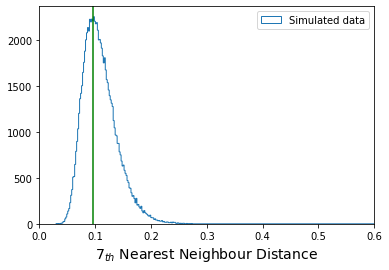

 33%|██████████████▎                            | 10/30 [00:50<01:40,  5.02s/it]

0.0967332333255332


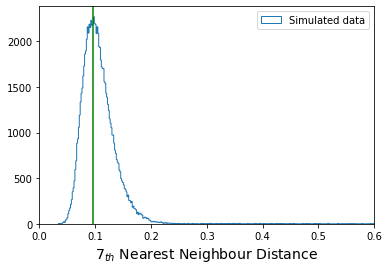

 37%|███████████████▊                           | 11/30 [00:55<01:38,  5.18s/it]

0.09670175980677495


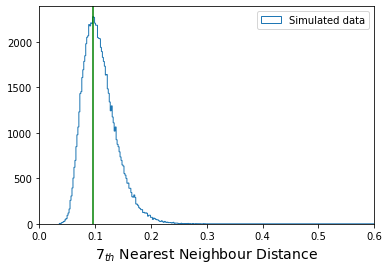

 40%|█████████████████▏                         | 12/30 [01:00<01:31,  5.11s/it]

0.09523023702033598


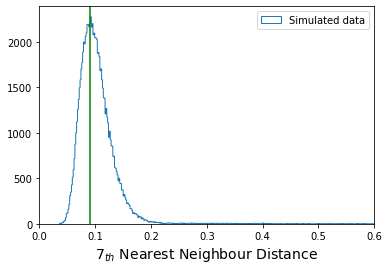

 43%|██████████████████▋                        | 13/30 [01:05<01:27,  5.16s/it]

0.09131379104038351


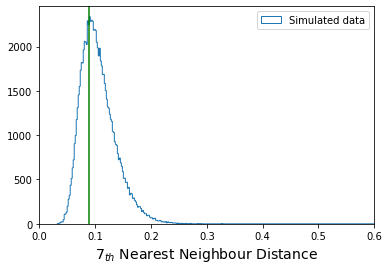

 47%|████████████████████                       | 14/30 [01:10<01:18,  4.93s/it]

0.08929950332082678


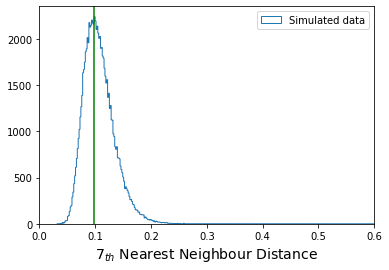

 50%|█████████████████████▌                     | 15/30 [01:14<01:13,  4.87s/it]

0.098182171798545


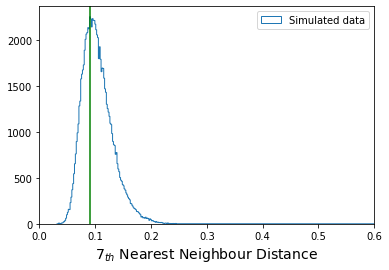

 53%|██████████████████████▉                    | 16/30 [01:20<01:10,  5.02s/it]

0.08977300106666132


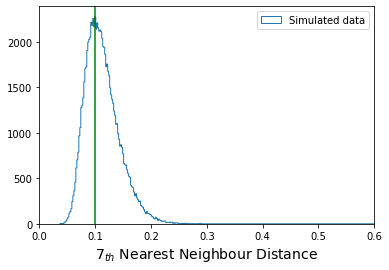

 57%|████████████████████████▎                  | 17/30 [01:24<01:03,  4.89s/it]

0.09910266060518236


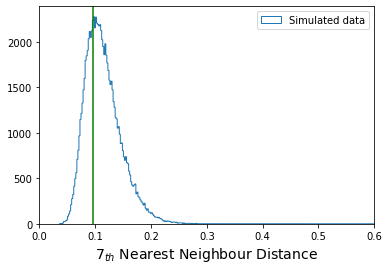

 60%|█████████████████████████▊                 | 18/30 [01:29<00:56,  4.72s/it]

0.09671246639040468


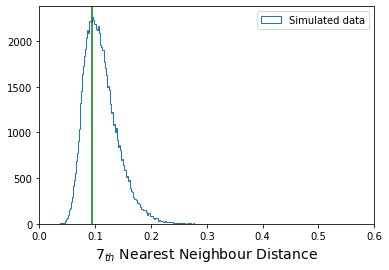

 63%|███████████████████████████▏               | 19/30 [01:33<00:51,  4.70s/it]

0.09463118120563194


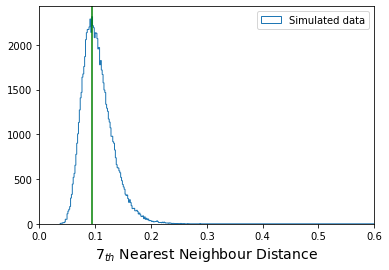

 67%|████████████████████████████▋              | 20/30 [01:39<00:49,  4.91s/it]

0.09354907240127386


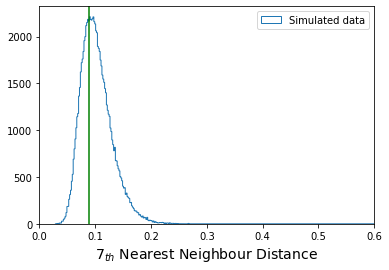

 70%|██████████████████████████████             | 21/30 [01:44<00:43,  4.87s/it]

0.08943390608801649


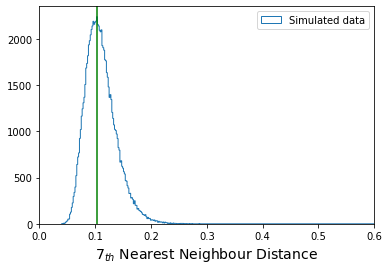

 73%|███████████████████████████████▌           | 22/30 [01:49<00:39,  4.91s/it]

0.10229692789142586


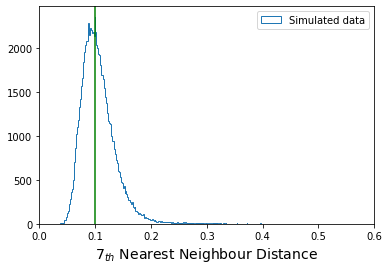

 77%|████████████████████████████████▉          | 23/30 [01:53<00:34,  4.91s/it]

0.09866014947694463


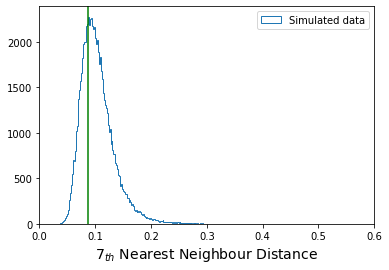

 80%|██████████████████████████████████▍        | 24/30 [01:58<00:29,  4.88s/it]

0.08745428293095023


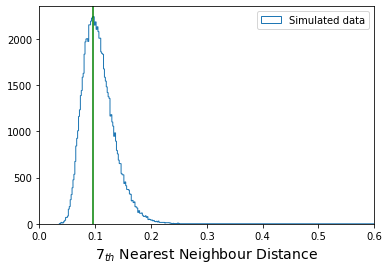

 83%|███████████████████████████████████▊       | 25/30 [02:03<00:24,  4.92s/it]

0.09656767158565203


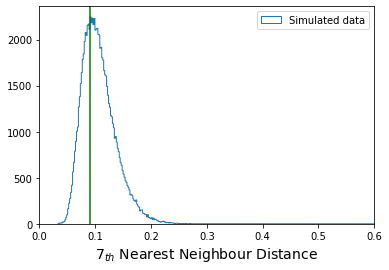

 87%|█████████████████████████████████████▎     | 26/30 [02:08<00:19,  4.78s/it]

0.09070203921338738


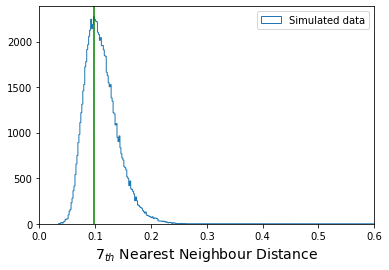

 90%|██████████████████████████████████████▋    | 27/30 [02:12<00:14,  4.69s/it]

0.09694337519464433


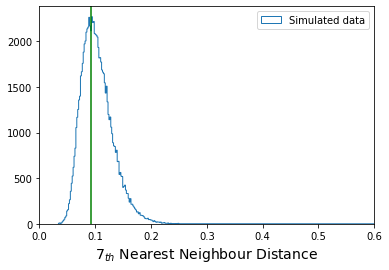

 93%|████████████████████████████████████████▏  | 28/30 [02:17<00:09,  4.69s/it]

0.09324937361474282


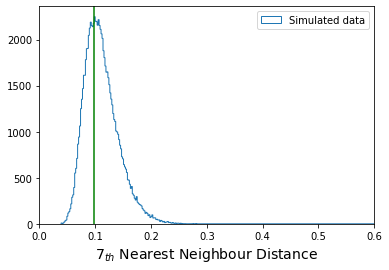

 97%|█████████████████████████████████████████▌ | 29/30 [02:21<00:04,  4.62s/it]

0.09814508960299265


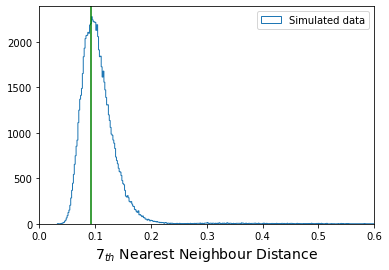

100%|███████████████████████████████████████████| 30/30 [02:26<00:00,  4.90s/it]

0.09300224710966096


In [7]:
eps_simulated = []
for k in tqdm(range(0,30)):
    names = ['ra','dec','pmra','pmdec','parallax']
    simulated_data = []
    for i in names:
        n_iteraciones = len(df[i])
        random_data = np.ones(n_iteraciones)
        mu, std = np.mean(df[i]), np.std(df[i])
        for j in range(1, n_iteraciones):
            random_data[j] = metropolis_hastings(random_data[j-1], mu, std, delta=1)
        simulated_data.append(random_data)
        random_teorico = np.linspace(min(random_data), max(random_data), len(df[i]))
        p_random_teorico = pdf(random_teorico, mu, std)

        #plt.hist(random_data, bins=50, density=True,alpha=0.5, label='Simulated data',histtype=u'step')
        #plt.plot(random_teorico, p_random_teorico, label='PDF')
        #plt.xlabel(i, fontsize=14)
        #plt.ylabel('Frequency',fontsize=14)
        #if i=='parallax':
        #    plt.xlim(0,5)
        #plt.legend()
        #plt.show()

    df_simulated = pd.DataFrame(np.array(simulated_data).transpose(), columns=['ra', 'dec','pmra','pmdec','parallax'])
    df_simulated = df_simulated.astype('float32')
    df_simulated = StandardScaler().fit(df_simulated).transform(df_simulated)

    neigh = NearestNeighbors(n_neighbors = 7, algorithm = 'kd_tree', n_jobs=8).fit(df_simulated)
    distances_simulated, indices = neigh.kneighbors(df_simulated)
    distances_simulated = np.sort(np.mean(distances_simulated, axis = 1))
    hist, bin_edges = np.histogram(distances_simulated, bins='auto',range=(min(distances_simulated),max(distances_simulated)))
    i = hist.argmax()

    #eps_simulated.append(min(distances_simulated))
    eps_simulated.append(bin_edges[i])
    
    #plt.hist(distances, bins='auto', label='Region of Blanco 1',histtype=u'step')
    plt.hist(distances_simulated, bins='auto', label='Simulated data',histtype=u'step')
    plt.xlabel(r'$7_{th}$ Nearest Neighbour Distance ', fontsize=14)
    plt.xlim(0,0.6)
    plt.axvline(eps_simulated[k],c='green')
    plt.legend()
    plt.show()
    print(eps_simulated[k])

In [8]:
np.savetxt('./pleiades_eps_simulated.txt', eps_simulated, delimiter=',')
eps_simulated

[0.08718338778243558,
 0.09506998964922951,
 0.09346410009958339,
 0.0917382828355827,
 0.0923385741731773,
 0.09686360930533522,
 0.10124791982414784,
 0.09839717094612253,
 0.09152874244048206,
 0.0967332333255332,
 0.09670175980677495,
 0.09523023702033598,
 0.09131379104038351,
 0.08929950332082678,
 0.098182171798545,
 0.08977300106666132,
 0.09910266060518236,
 0.09671246639040468,
 0.09463118120563194,
 0.09354907240127386,
 0.08943390608801649,
 0.10229692789142586,
 0.09866014947694463,
 0.08745428293095023,
 0.09656767158565203,
 0.09070203921338738,
 0.09694337519464433,
 0.09324937361474282,
 0.09814508960299265,
 0.09300224710966096]

# K Nearest Neighbour Distance

In [9]:
data = df[['ra','dec','pmra','pmdec','parallax']]
data = data.astype('float32')
data = StandardScaler().fit(data).transform(data)

neigh = NearestNeighbors(n_neighbors=7, algorithm = 'ball_tree',n_jobs=4).fit(data)
distances, indices = neigh.kneighbors(data)
distances = np.sort(np.mean(distances, axis = 1))

eps_simulated = np.loadtxt('./pleiades_eps_simulated.txt')

hist, bin_edges = np.histogram(distances, bins='auto',range=(min(distances),max(distances)))
i = hist.argmax()
max_value = bin_edges[i]
average_eps_simulated = np.average(eps_simulated)
average_distance = np.average(distances)
print(average_eps_simulated)

0.09451719725820223


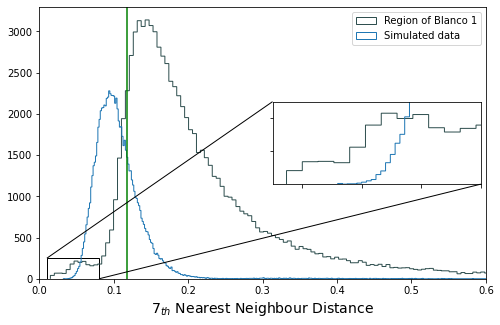

In [10]:
fig, ax = plt.subplots(figsize=[8, 5]) # create a new figure with a default 111 subplot
#plt.subplots_adjust(bottom = 0.15)
ax.hist(distances, bins='auto', label='Region of Blanco 1',histtype=u'step',color='darkslategray')
ax.hist(distances_simulated, bins='auto', label='Simulated data',histtype=u'step')
plt.xlabel(r'$7_{th}$ Nearest Neighbour Distance ', fontsize=14)
plt.xlim(0,0.6)
#plt.axvline(average_eps_simulated, label=r'Simulated $\epsilon=$ {:.09}'.format(0.11623179806790337),c='cyan')
#plt.axvline(max_value, label=r'7NND $\epsilon=$ {:.09}'.format(max_value),c='green')
plt.axvline((max_value+average_eps_simulated)/2,c='green')
plt.legend()

axins = zoomed_inset_axes(ax, 4, loc = 7) # zoom-factor: 2.5, location: upper-left
axins.hist(distances, bins='auto', label='Region of Blanco 1',histtype=u'step',color='darkslategray')#x1, x2, y1, y2 = 14, 24, -3, 7 # specify the limits
axins.hist(distances_simulated, bins='auto', label='Simulated data',histtype=u'step')
x1, x2, y1, y2 = 0.01, 0.08, 0.010, 250
axins.set_xlim(x1, x2) 
axins.set_ylim(y1, y2) 
plt.yticks(visible = False)
plt.xticks(visible = False)
mark_inset(ax, axins, loc1 = 2, loc2 = 4, fc = "white", ec = "black", linewidth = 1)
#axins.grid()
axins.spines['bottom'].set_color('black')
axins.spines['top'].set_color('black')
axins.spines['right'].set_color('black')
axins.spines['left'].set_color('black')
#plt.savefig('./knnd.png',bbox_inches='tight')

In [23]:
print('max_value:',max_value)
print('Average eps simulated:',average_eps_simulated)
eps = (average_eps_simulated + max_value)/2
print('eps:',eps)

max_value: 0.14205534625833208
Average eps simulated: 0.09451719725820223
eps: 0.11828627175826716


In [12]:
db = DBSCAN(eps = eps, min_samples = 8, n_jobs = 8, algorithm='ball_tree').fit(data)
labels = db.labels_ 
df['Clusters'] = labels
for i in list(set(labels)):
    print('{} {}'.format(i,len(df[(df['Clusters'] == i)])))

0 9
1 435
2 469
3 97
4 13
5 8
6 847
7 8
8 10
9 8
10 9
11 100
12 13
13 9
14 11
15 9
16 8
17 9
18 8
19 8
-1 84876


In [13]:
#for i in list(set(labels)):
#    if len(df[(df['Clusters'] == i)]) > 50:
#        print('{} {}'.format(i,len(df[(df['Clusters'] == i)])))

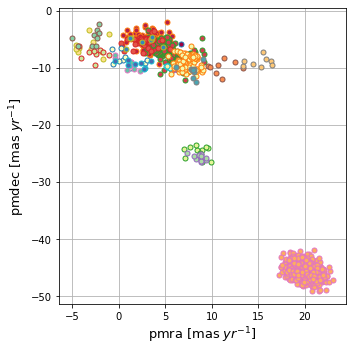

In [42]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(5,5))
for i, j in zip(list(unique_labels), colors):
    if not i == -1:# or i == 0:
        plt.plot(df['pmra'][(df['Clusters'] == i)], df['pmdec'][(df['Clusters'] == i)], 
         markerfacecolor = tuple(j),marker = 'o', linestyle='None',markersize = 5, alpha = 1)
#else:
        #plt.plot(df['pmra'][(df['Clusters'] == i)], df['pmdec'][(df['Clusters'] == i)], 
        # color = 'black', marker='o' ,linestyle = 'None', markersize = 5, alpha = 1)
        #plt.scatter(0,0,marker='.')
plt.xlabel("pmra [mas $yr^{-1}$]",  fontsize = 13)
plt.ylabel("pmdec [mas $yr^{-1}$]",  fontsize = 13)#,rotation=0)
#plt.xlim(-40,20)
#plt.ylim(-20,40)
plt.tight_layout()
plt.grid()
plt.savefig('./dbscan_images/pleiades_vpd_dbscan_complete.jpg',bbos_inches='tight')
plt.show() #should be on pmra(-26,-16) and pmdec(10,20)

<Figure size 360x360 with 0 Axes>

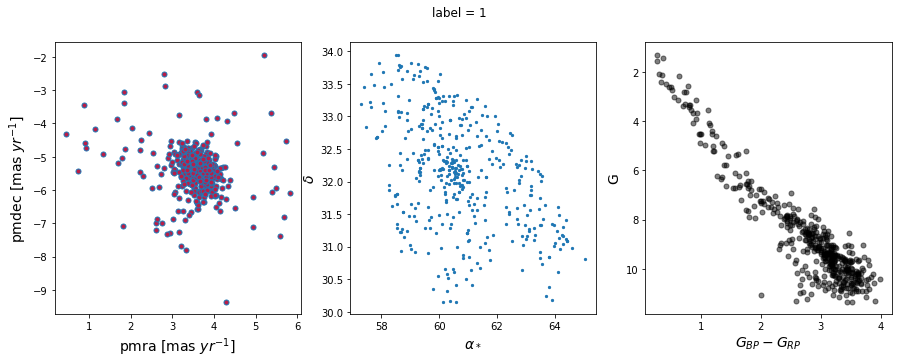

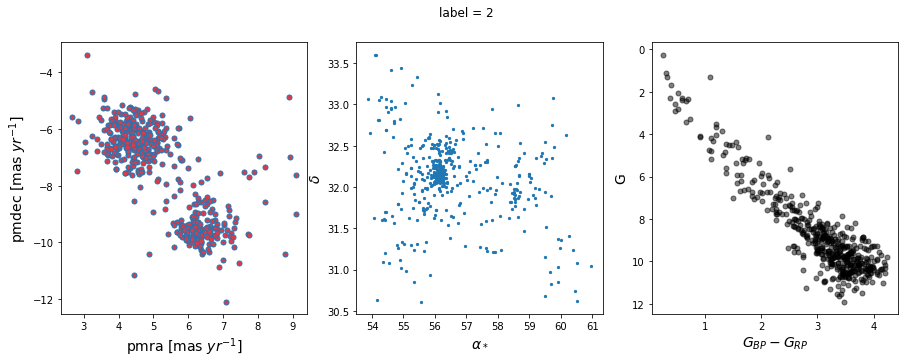

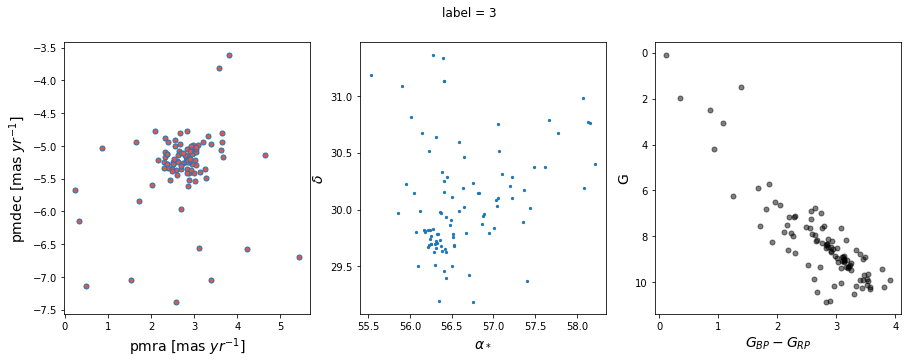

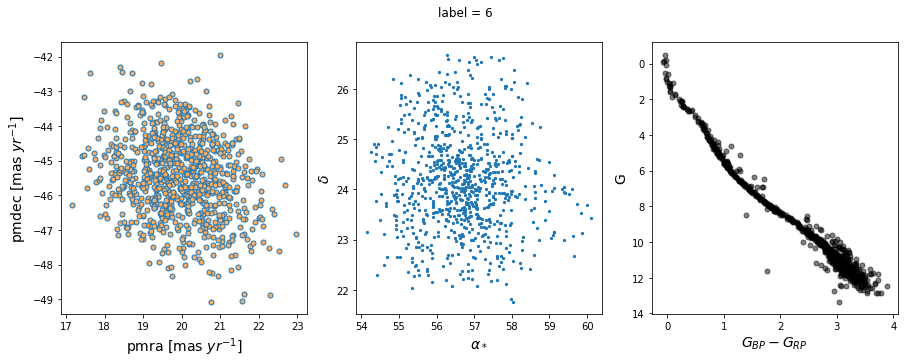

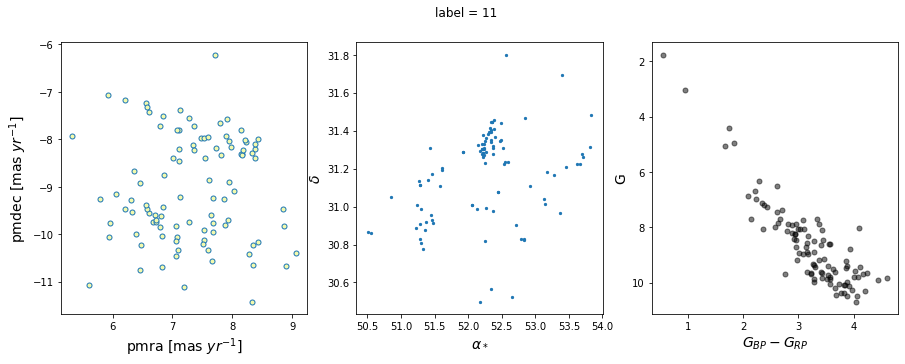

In [27]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(5,5))
for i, j in zip(list(unique_labels), colors):
    if not i == -1 and len(df[(df['Clusters'] == i)]) > 50:# or i == 0:
        
        plt.figure(figsize=(15,5))
        plt.suptitle('label = {}'.format(i))
        plt.subplot(1,3,1)
        plt.plot(df['pmra'][(df['Clusters'] == i)], df['pmdec'][(df['Clusters'] == i)], 
         markerfacecolor = tuple(j),marker = 'o', linestyle='None',markersize = 5, alpha = 1)
        plt.xlabel("pmra [mas $yr^{-1}$]",  fontsize = 14)
        plt.ylabel("pmdec [mas $yr^{-1}$]",  fontsize = 14)#,rotation=0)
        
        plt.subplot(1,3,2)
        plt.scatter(df['ra'][(df['Clusters'] == i)], df['dec'][(df['Clusters'] == i)], marker='o' , s=5, alpha = 1)
        plt.xlabel(r'$\alpha_*$',fontsize = 14)
        plt.ylabel(r'$\delta$',fontsize = 14)
        
        g_mag = df['g'][(df['Clusters'] == i)] + 5 - 5*np.log10(1/df['parallax'][(df['Clusters'] == i)])
        color = df['bp'][(df['Clusters'] == i)] - df['rp'][(df['Clusters'] == i)]
        plt.subplot(1,3,3)
        plt.plot(color, g_mag,color='black',marker='o',linestyle='None',markersize=5,alpha=0.5)
        plt.xlabel("$G_{BP}-G_{RP}$", fontsize = 14)
        plt.ylabel("G", fontsize = 14)
        plt.gca().invert_yaxis()

plt.show() #should be on pmra(-26,-16) and pmdec(10,20)

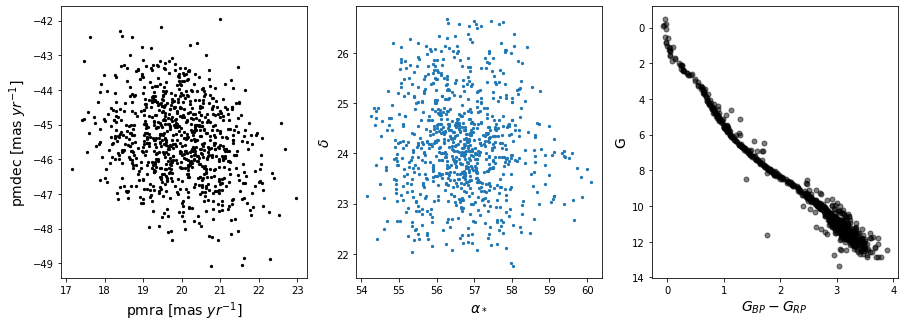

In [28]:
n = 6
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(df['pmra'][(df['Clusters'] == n)], df['pmdec'][(df['Clusters'] == n)], 
             color = 'black', marker='o' , s = 5, alpha = 1)
plt.xlabel("pmra [mas $yr^{-1}$]", fontsize = 14)
plt.ylabel("pmdec [mas $yr^{-1}$]", fontsize = 14)#,rotation=0)
#plt.xlim(-40,20)
#plt.ylim(-20,40)

plt.subplot(1,3,2)
plt.scatter(df['ra'][(df['Clusters'] == n)], df['dec'][(df['Clusters'] == n)], marker='o' , s=5, alpha = 1)
plt.xlabel(r'$\alpha_*$',fontsize = 14)
plt.ylabel(r'$\delta$',fontsize = 14)

g_mag = df['g'][(df['Clusters'] == n)] + 5 - 5*np.log10(1/df['parallax'][(df['Clusters'] == n)])
color = df['bp'][(df['Clusters'] == n)] - df['rp'][(df['Clusters'] == n)]
plt.subplot(1,3,3)
plt.plot(color, g_mag,color='black',marker='o',linestyle='None',markersize=5,alpha=0.5)
plt.xlabel("$G_{BP}-G_{RP}$", fontsize = 14)
plt.ylabel("G", fontsize = 14)
plt.gca().invert_yaxis()
#plt.savefig('./vpd.jpg')
plt.show()

In [29]:
df_test = df[(df['Clusters'] == n)]
df_test.to_csv('./pleiades_dbscan.csv')

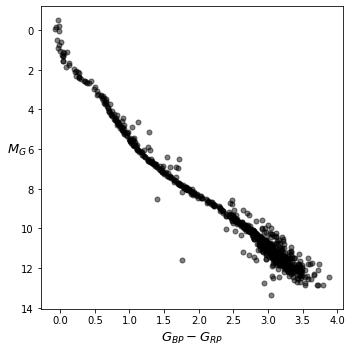

In [43]:
plt.figure(figsize=(5,5))
plt.plot(color, g_mag,color='black',marker='o',linestyle='None',markersize=5,alpha=0.5)
plt.xlabel("$G_{BP}-G_{RP}$", fontsize = 13)
plt.ylabel(r"$M_G$", fontsize = 13, rotation=0)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('./dbscan_images/pleiades_cmd_dbscan.jpg',bbos_inches='tight')
plt.show()

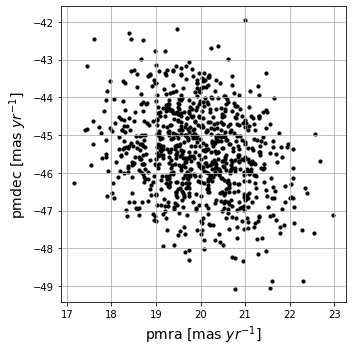

In [44]:
plt.figure(figsize=(5,5))
plt.grid()
plt.scatter(df['pmra'][(df['Clusters']==n)],df['pmdec'][(df['Clusters']==n)],color='black',marker='o',s=10,alpha=1)
plt.xlabel("pmra [mas $yr^{-1}$]", fontsize = 14)
plt.ylabel("pmdec [mas $yr^{-1}$]", fontsize = 14)#,rotation=0)
#plt.xlim(-40,20)
#plt.ylim(-20,40)
plt.tight_layout()
plt.savefig('./dbscan_images/pleiades_vpd_dbscan.jpg',bbos_inches='tight')
plt.show()